In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import pyplot

In [9]:
path = open('document.txt', 'r').read().strip()
os.listdir(f'{path}')

df_data = pd.DataFrame([])
for year in range(2015,2019):
    df_temp = pd.read_feather(f"{path}/{year}_street.feather")
    filter = df_temp['Falls within'].str.contains('South Wales')
    df_temp = df_temp[filter]
    df_temp = df_temp[df_temp['Crime type']=='Violence and sexual offences']
    df_temp = df_temp['Month'].value_counts().sort_index()
    df_data = pd.concat([df_data, df_temp])
    del df_temp

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_data.index = pd.to_datetime(df_data.index)

decomposition = seasonal_decompose(df_data, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

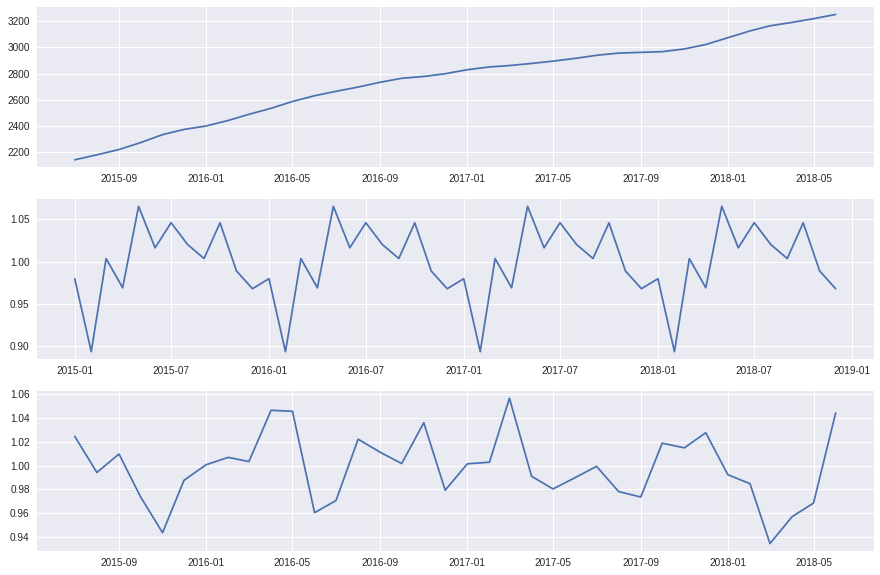

In [32]:
fig, ax = plt.subplots(nrows=3, figsize=(15,10))
ax[0].plot(trend);
ax[1].plot(seasonal);
ax[2].plot(residual);


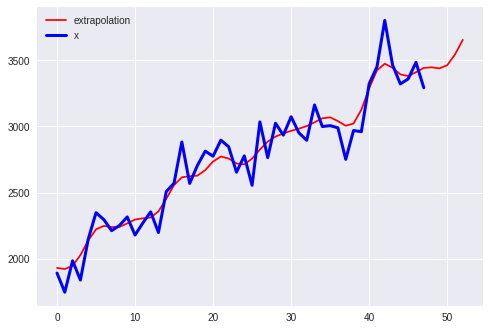

In [117]:
import numpy as np
import pylab as pl
from numpy import fft
    
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 5                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes = list(range(n))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    

x = df_data[0].to_numpy()
n_predict = 5
extrapolation = fourierExtrapolation(x, n_predict)
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
pl.legend()
pl.show()
    
